In [106]:
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
import string
import random
import scipy
from scipy import signal
from sklearn.decomposition import FastICA, PCA
from sklearn.preprocessing import normalize

from matplotlib import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
%matplotlib inline
"""
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html
http://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_vs_pca.html#sphx-glr-auto-examples-decomposition-plot-ica-vs-pca-py
"""
N = 1000
alphabet = string.ascii_lowercase + '#' + '.'
D = len(alphabet)
z = np.ones(N)

RI_pres = np.random.rand(D, N)
RI_pres = np.where(RI_pres>0.5, 1, -1)

RI_past = np.random.rand(D, N)
RI_past = np.where(RI_past>0.5, 1, -1)

def read_csv(filepath):
    present, past = [], []
    freqdist = []
    num_words = 0
    with open(filepath, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:          
            present.append(row[0])
            past.append(row[1])
            freqdist.append(float(row[2]))
            num_words += 1
    freqdist = np.asarray(freqdist)
    # true probability is weights/np.sum(weights,axis=0). 
    # 1 - is to emphasize smaller freqs. idk 
    freqdist = 1-freqdist/np.sum(freqdist,axis=0)
    # force sum to 1
    freqdist = freqdist/np.sum(freqdist,axis=0)
    return freqdist, present, past, num_words

def ngram_encode(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.'
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, window=3):
    vec = np.zeros(letter_vecs.shape[1])
    full_str = '#' + ngram_str + '.'
    for il, l in enumerate(full_str[:-(window-1)]):
        trivec = letter_vecs[alphabet.find(full_str[il]), :]
        for c3 in range(1, window):
            trivec = trivec * np.roll(letter_vecs[alphabet.find(full_str[il+c3]), :], c3)     
        vec += trivec
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) < 0) - 1
            
def sample(X, num_samples, freqdist, mu, sigma):
    indices = np.random.choice(X.shape[0], num_samples, p=freqdist)
    X_sampled = X[indices] + np.random.normal(mu, sigma, (num_samples, N))
    return X_sampled, indices

def gen_diffs(present, past, RI_pres, RI_past, ngram_length):
    X = np.zeros((len(past), N))
    for i in range(X.shape[0]):
        X[i] = (ngram_encode(past[i], RI_past, ngram_length) 
                        - ngram_encode(present[i], RI_pres, ngram_length))
        
    #return normalize(X,axis=0)
    return X

In [107]:
reg_freqdist, reg_pres, reg_past, reg_num_pairs = read_csv("data/cleaned/regular_verbs_clean.csv")
irreg_freqdist, irreg_pres, irreg_past, irreg_num_pairs = read_csv("data/cleaned/irregular_verbs_clean.csv")

pres, past = reg_pres + irreg_pres, reg_past + irreg_past
num_pairs = reg_num_pairs + irreg_num_pairs
freqdist = np.zeros(num_pairs)
freqdist[:reg_num_pairs] = reg_freqdist
freqdist[reg_num_pairs:] = irreg_freqdist
freqdist /= np.sum(freqdist,axis=0)

# upsampling doesn't work with regular and irregular mixed together?
# also data looks really messy so idk if upsampling is a good idea

ngram_length 2


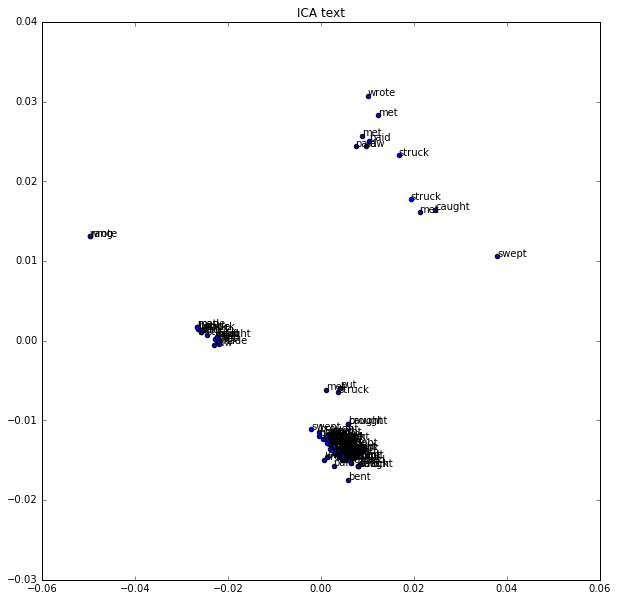

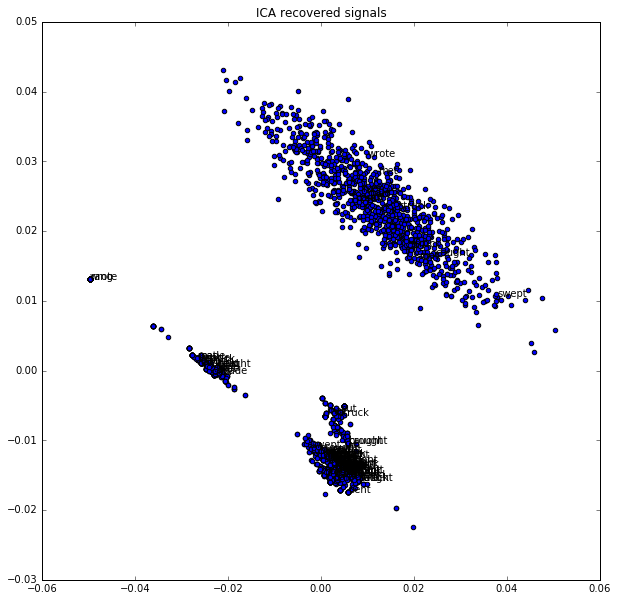

ngram_length 3


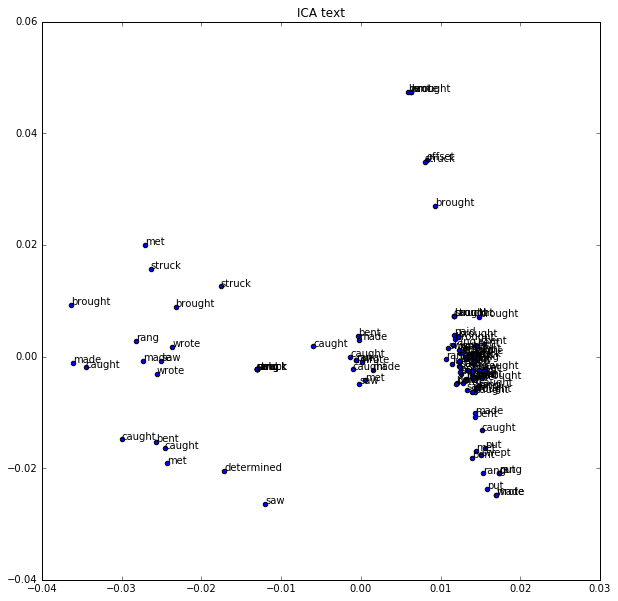

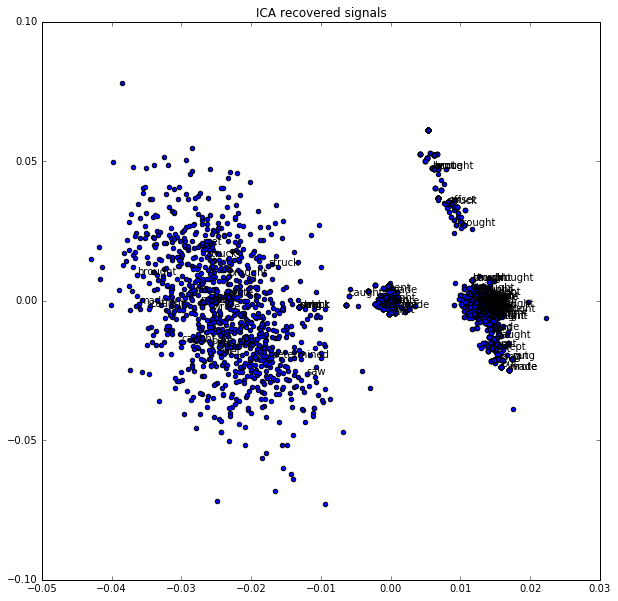

ngram_length 4


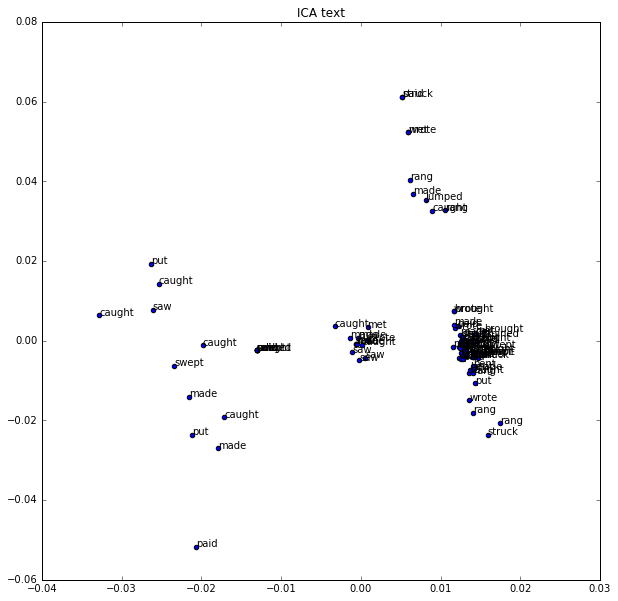

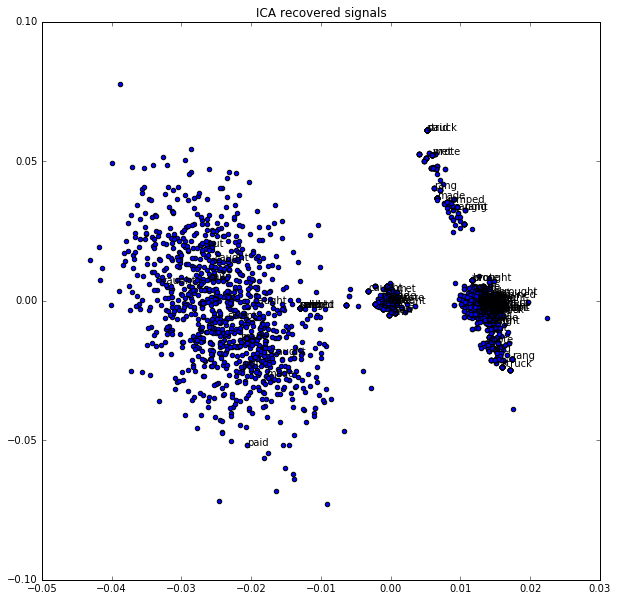

In [108]:
num_samples = 3000
mu = 0
sigma = 10
ngram_lengths = [2, 3, 4]
# regulars
txt_to_graph = ["jumped", "made", "brought", "determined", "offset", \
                "paid", "chid", "robbed"]
# irregulars
txt_to_graph += ["put", "bent", "swept", "caught", "wrote", "met", \
               "rang", "rose", "struck", "saw"]
for ngram_length in ngram_lengths:
    print "ngram_length %d" % ngram_length
    X = gen_diffs(pres, past, RI_past, RI_past, ngram_length)
    X_sampled, indices = sample(X, num_samples, freqdist, mu, sigma)

    ica = FastICA(n_components=3)
    S_ica = ica.fit(X_filled).transform(X_filled)
   
    pc1 = 0
    pc2 = 2
    
    # 2d
    ic1 = 0
    ic2 = 1
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    for i in range(num_samples):
        if past[indices[i]] in txt_to_graph:
            ax.annotate(past[indices[i]], [S_ica[i][ic1], S_ica[i][ic2]])
            plt.scatter(S_ica[i,ic1], S_ica[i,ic2]) 
    #plt.scatter(S_ica[:,ic1], S_ica[:,ic2]) 

    plt.title('ICA text')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10,10))
    for i in range(num_samples):
        if past[indices[i]] in txt_to_graph:
            ax.annotate(past[indices[i]], [S_ica[i][ic1], S_ica[i][ic2]])
            plt.scatter(S_ica[i,ic1], S_ica[i,ic2]) 
    plt.scatter(S_ica[:,ic1], S_ica[:,ic2]) 

    plt.title('ICA recovered signals')
    plt.show()
    
    